# Ensemble of Unit Tests for my streamlined python version of Okada (1992) scripts
Updated by George Lu on September 19, 2024


The base code is likely much slower than its FORTRAN counterparts, but it runs on Mac M1 chips. This notebook focuses on testing the code to make sure it's producing valid results. To test, we will test unit strike, dip, and tensile dislocations along with different dip angles ranging from 0 to 90 degrees. We will plot the resulting surface u_x, u_y, u_z displacements. 

The remaining setup geometry follows that of `test_okada.py` from [Ben Thompson's Okada wrapper scripts](https://github.com/tbenthompson/okada_wrapper/blob/master/test_okada.py). 

In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io
import sys
import os
import time

sys.path.append(os.path.abspath('okada_python_scripts/..'))

from okada_python_scripts_streamlined.DC3D import DC3D

In [2]:
# define a plotting function to plot u_x, u_y, u_z for a specific dip value
def plot_displacements(u_x,u_y,u_z,dip):
    fig , axs = plt.subplots(figsize=(10,2), ncols= 3, sharex = True, sharey = True,layout = 'constrained')

    cntrf = axs[0].pcolormesh(x, y, u_x,norm=colors.CenteredNorm(),cmap='RdBu_r')
    axs[0].set_xlabel(r'$\mathrm{x}$')
    axs[0].set_ylabel(r'$\mathrm{y}$')
    axs[0].set_title(r'$u_{\mathrm{x}}$')
    plt.colorbar(cntrf,ax=axs[0])

    cntrf = axs[1].pcolormesh(x, y, u_y,norm=colors.CenteredNorm(), cmap='RdBu_r')
    axs[1].set_xlabel(r'$\mathrm{x}$')
    #axs[1].set_ylabel(r'$\mathrm{y}$')
    axs[1].set_title(r'$u_{\mathrm{y}}$')
    plt.colorbar(cntrf,ax=axs[1])

    cntrf = axs[2].pcolormesh(x, y, u_z,norm=colors.CenteredNorm(), cmap='RdBu_r')
    axs[2].set_xlabel(r'$\mathrm{x}$')
    #axs[2].set_ylabel(r'$\mathrm{y}$')
    axs[2].set_title(r'$u_{\mathrm{z}}$')
    plt.colorbar(cntrf,ax=axs[2])

    fig.suptitle(f'Dip = {int(dip)}')

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap

def plot3D(X,Y,Z,U,dip):
    q = Z.shape[2]
    # Create figure and subplots
    fig = plt.figure(figsize=(20, 6))

    cmap = get_cmap('RdBu_r')

    titles = [r'$u_{\mathrm{x}}$',r'$u_{\mathrm{y}}$',r'$u_{\mathrm{z}}$']
    # Loop over the 3 components (last dimension of U)
    for i in range(3):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        norm = colors.CenteredNorm(halfrange = np.max(np.abs(U[...,i])))


        for j in range(q):
            # Get the U values for the current component and q slice
            # Create the surface plot with the color as the U value
            C = U[...,j,i]
            C_normalized = norm(C)
            color = cmap(C_normalized)
            surf = ax.plot_surface(X[...,0], Y[...,0], -Z[...,j], facecolors=color, shade=False)

            # Customize the plot
            ax.set_title(titles[i])
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')

        # Add color bar for each subplot
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.25, aspect=20, pad=0.12)
        cbar.set_label(titles[i]+ ' [cm]')

    plt.subplots_adjust(right=0.75)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  
    fig.suptitle(f'Dip = {int(dip)}',x=0.45)
    plt.show()

In [4]:
# using test from https://github.com/tbenthompson/okada_wrapper/blob/master/test_okada.py
# set constant values
source_depth = 3.0
obs_depth = 0
poisson_ratio = 0.25
mu = 1.0
patch_dim = [-0.6,0.6,-0.6,0.6] # al1, al2, aw1, aw2
lmda = 2 * mu * poisson_ratio / (1 - 2 * poisson_ratio)
alpha = (lmda + mu) / (lmda + 2 * mu)


In [5]:
# initialize values of dip angles to test and grid
dips = [0, 45, 90]
n = (100,102,3,3,12) #I also make 102 points in the y dimension just to distinguish it from the x dimension
x = np.linspace(-1,1,n[0])
y = np.linspace(-1,1,n[1])
z = np.array([0,1,2])
X,Y,Z = np.meshgrid(x,y,z)


A note on how the DC3D subroutine is called. For an observation point x, y, z (z is negative), it calculates the u_x, u_y, u_z (along with strain) with the following:

`DC3D(ALPHA, X, Y, Z, SOURCE DEPTH, DIP, AL1, AL2, AW1, AL2, DISL1, DISL2, DISL3)`

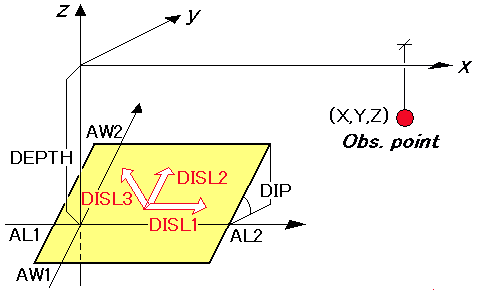

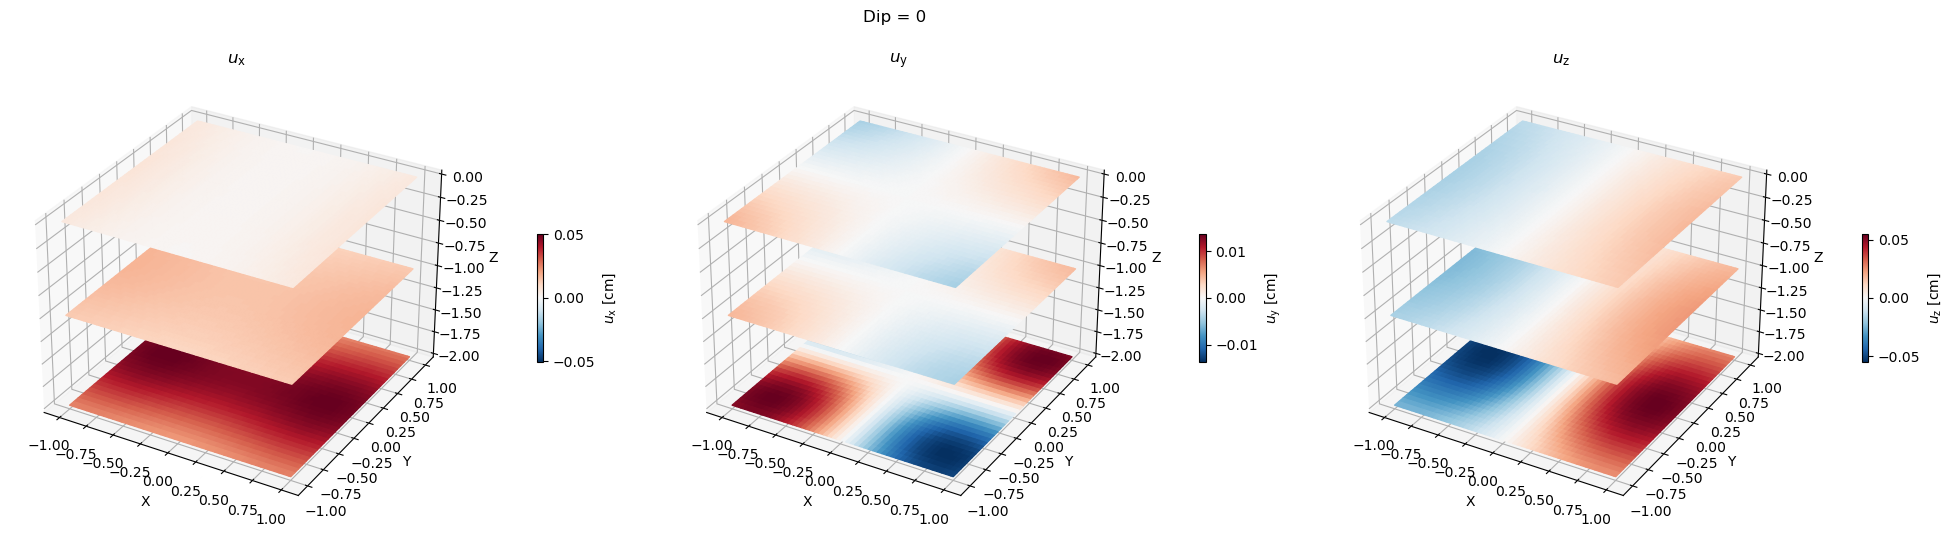

/Users/georgelu/Documents/GitHub/okada_python/okada_python_scripts_streamlined/calculate_constants.py:44: RuntimeWarning: divide by zero encountered in divide
  c2['tt'] = np.where((q == 0) | (r0_condition), 0, np.arctan(xi * et / (q * c2['r'])))


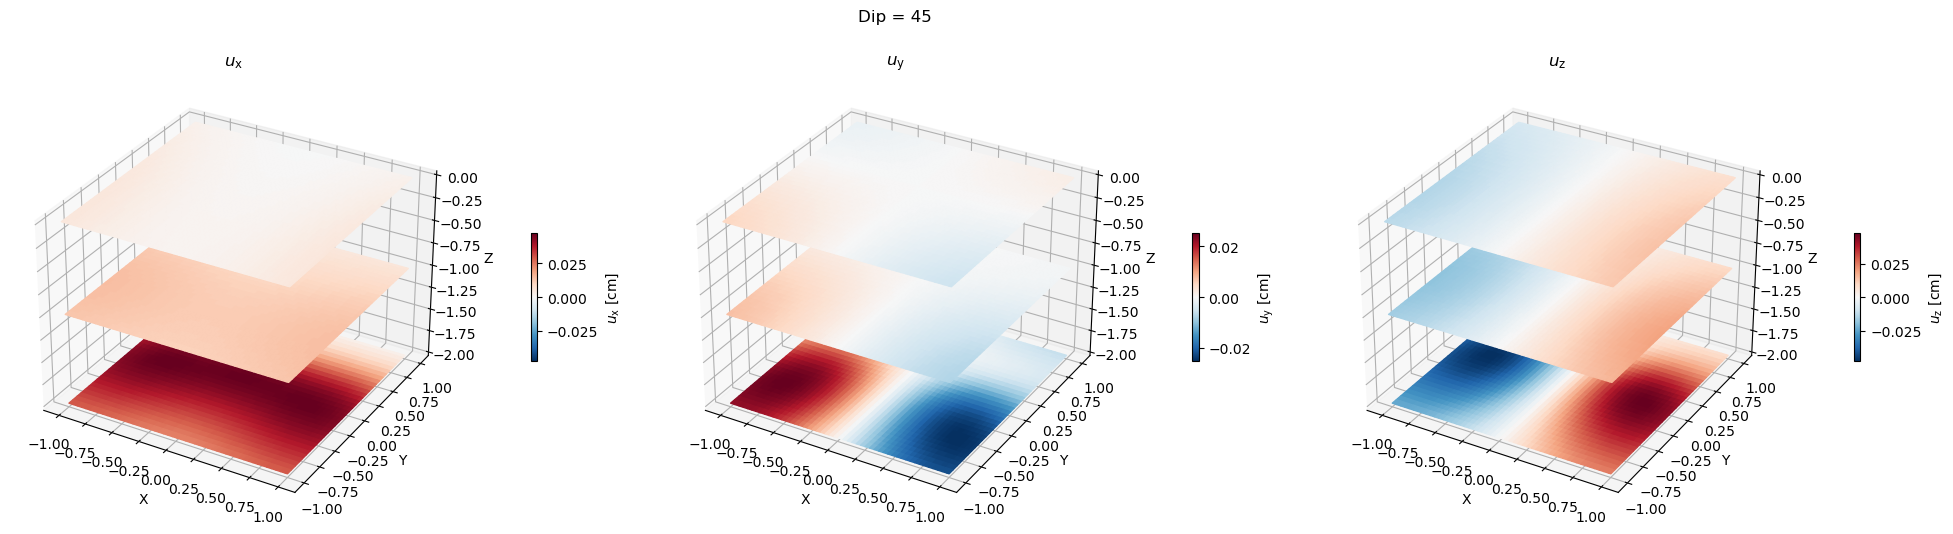

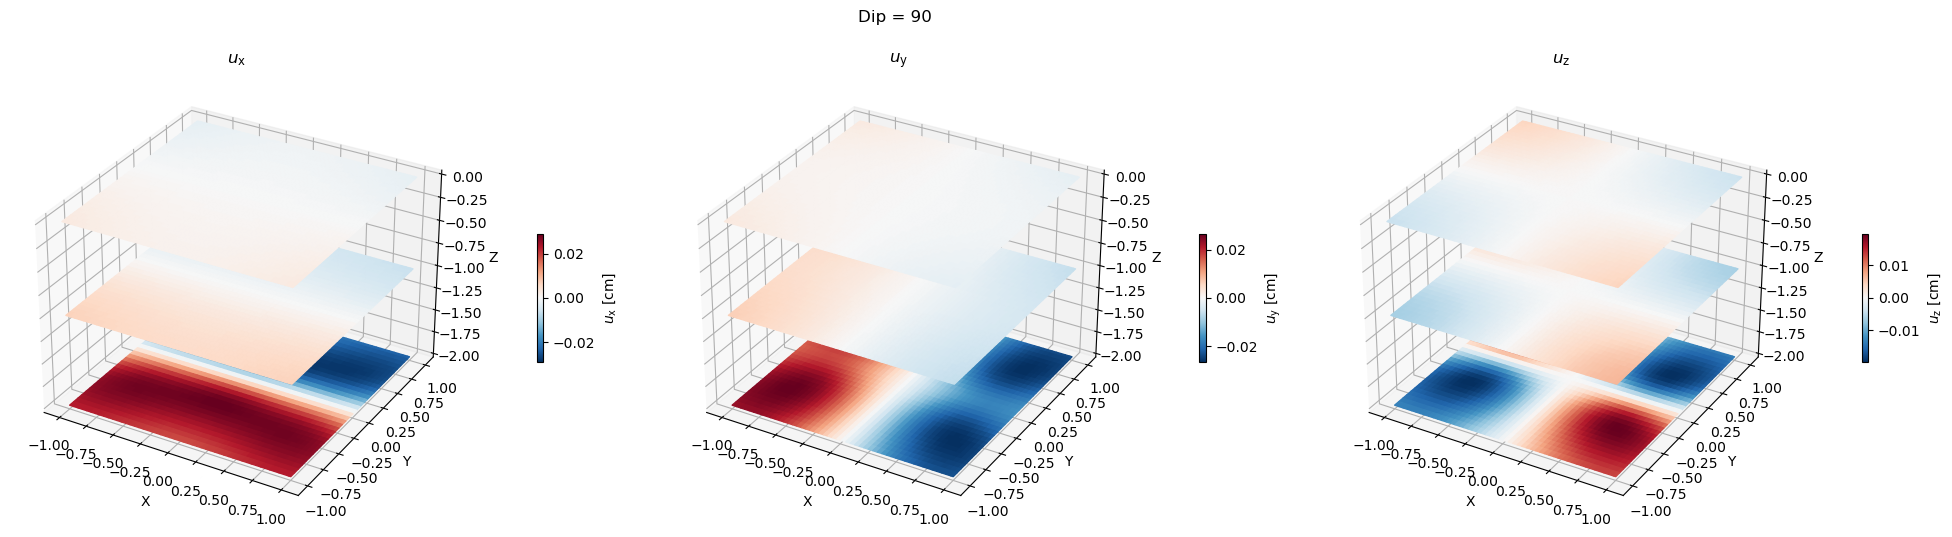

Elapsed time: 12.86832571029663 seconds


In [6]:
# run calculations for a strike slip of 1 
disl1 = 1 # strike
disl2 = 0 # dip
disl3 = 0 # tensile
U_strike = np.zeros(n)
start_time = time.time()
for i in range(n[2]):
    U = DC3D(alpha,X,Y,-Z,source_depth,dips[i],patch_dim[0],patch_dim[1],patch_dim[2],patch_dim[3],disl1,disl2,disl3)
    plot3D(X,Y,Z,U,dips[i])
    U_strike[...,i,:] = np.transpose(U, (1, 0, 2, 3))
elapsed_time = time.time() - start_time 
print(f"Elapsed time: {elapsed_time} seconds")

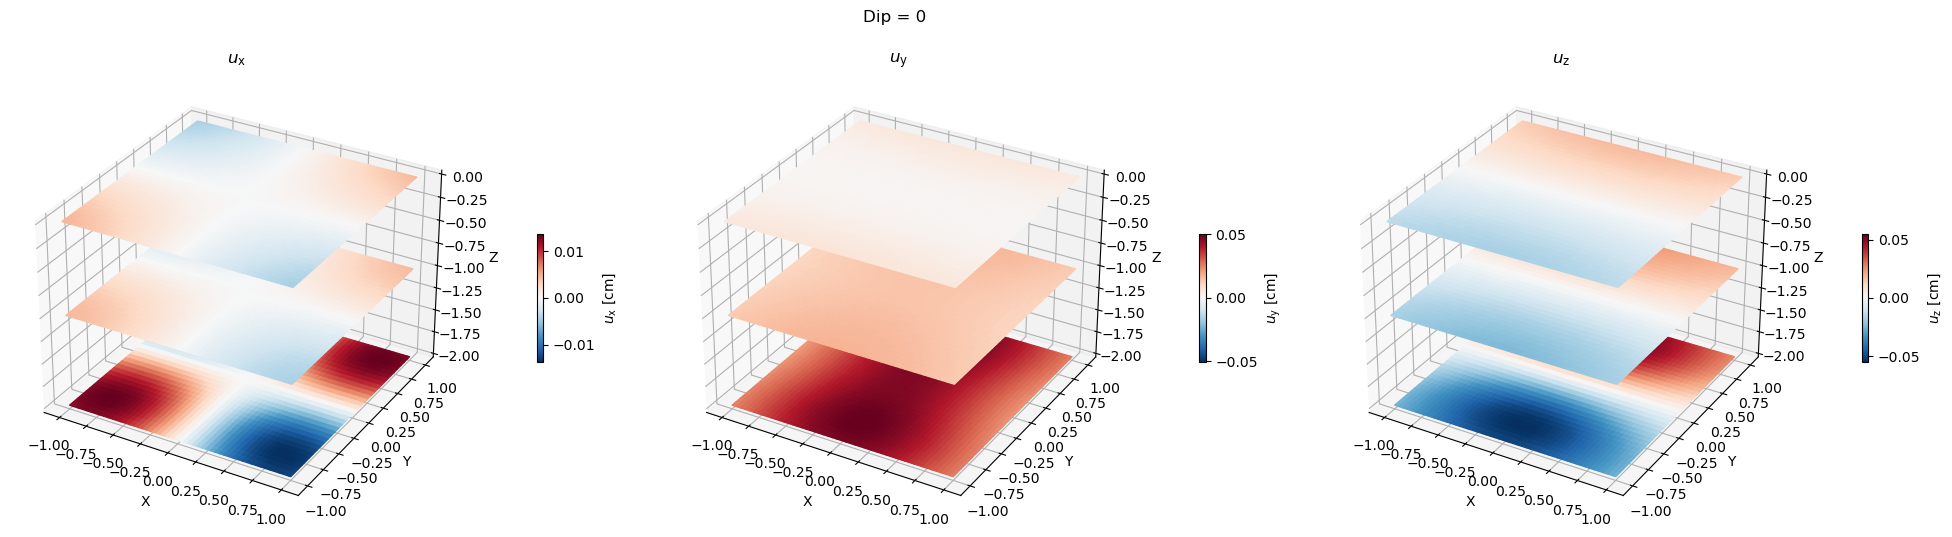

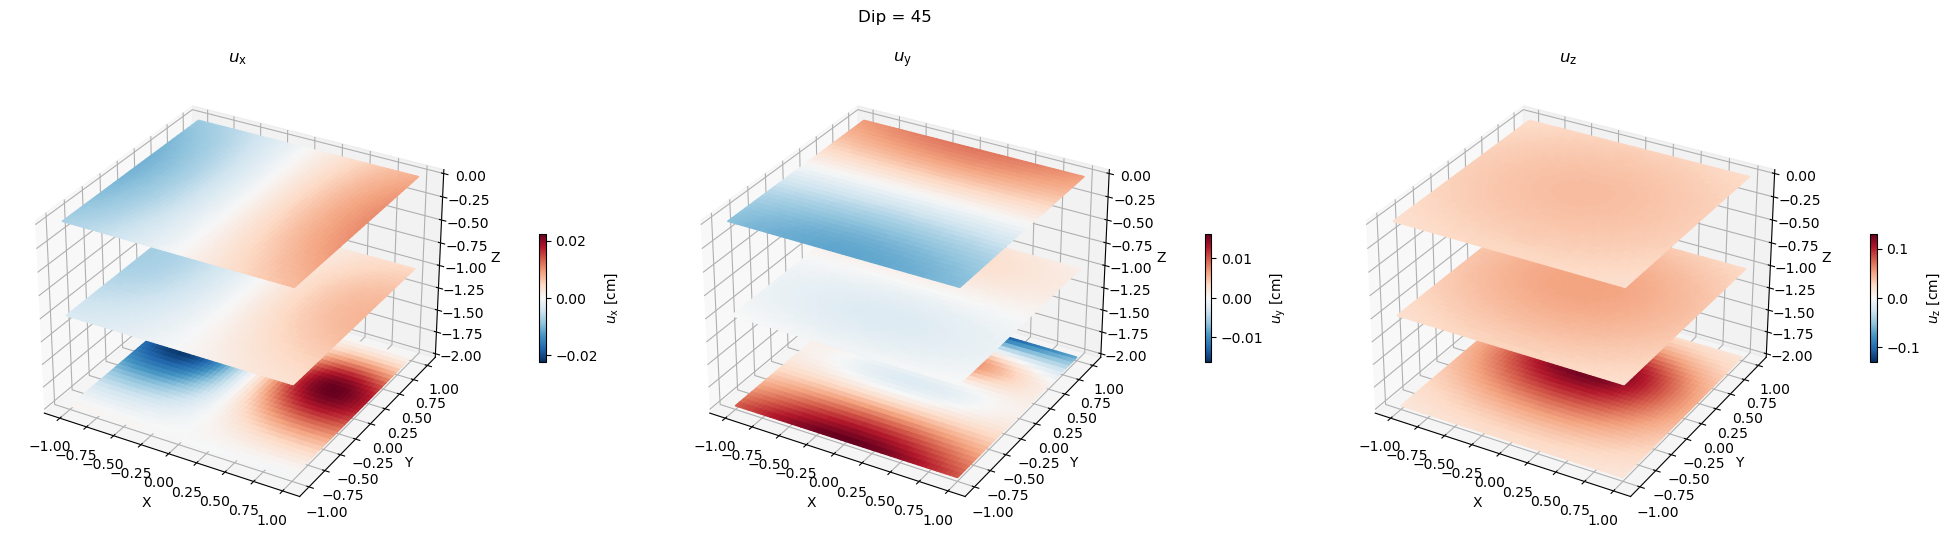

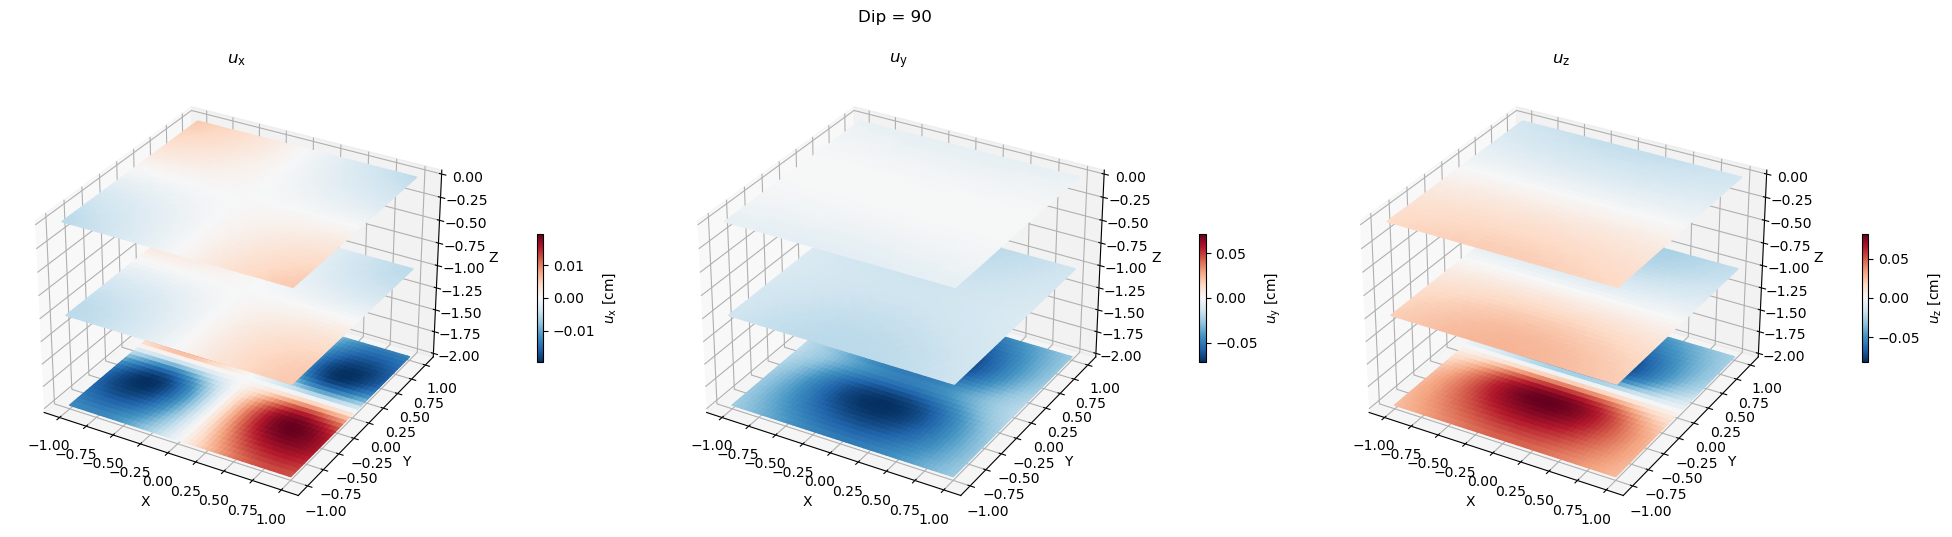

Elapsed time: 12.267844915390015 seconds


In [7]:
# run calculations for a dip slip of 1 
disl1 = 0 # strike
disl2 = 1 # dip
disl3 = 0 # tensile
U_dip = np.zeros(n)
start_time = time.time()
for i in range(n[2]):
    U = DC3D(alpha,X,Y,-Z,source_depth,dips[i],patch_dim[0],patch_dim[1],patch_dim[2],patch_dim[3],disl1,disl2,disl3)
    plot3D(X,Y,Z,U,dips[i])
    U_dip[...,i,:] = np.transpose(U, (1, 0, 2, 3))
elapsed_time = time.time() - start_time 
print(f"Elapsed time: {elapsed_time} seconds")

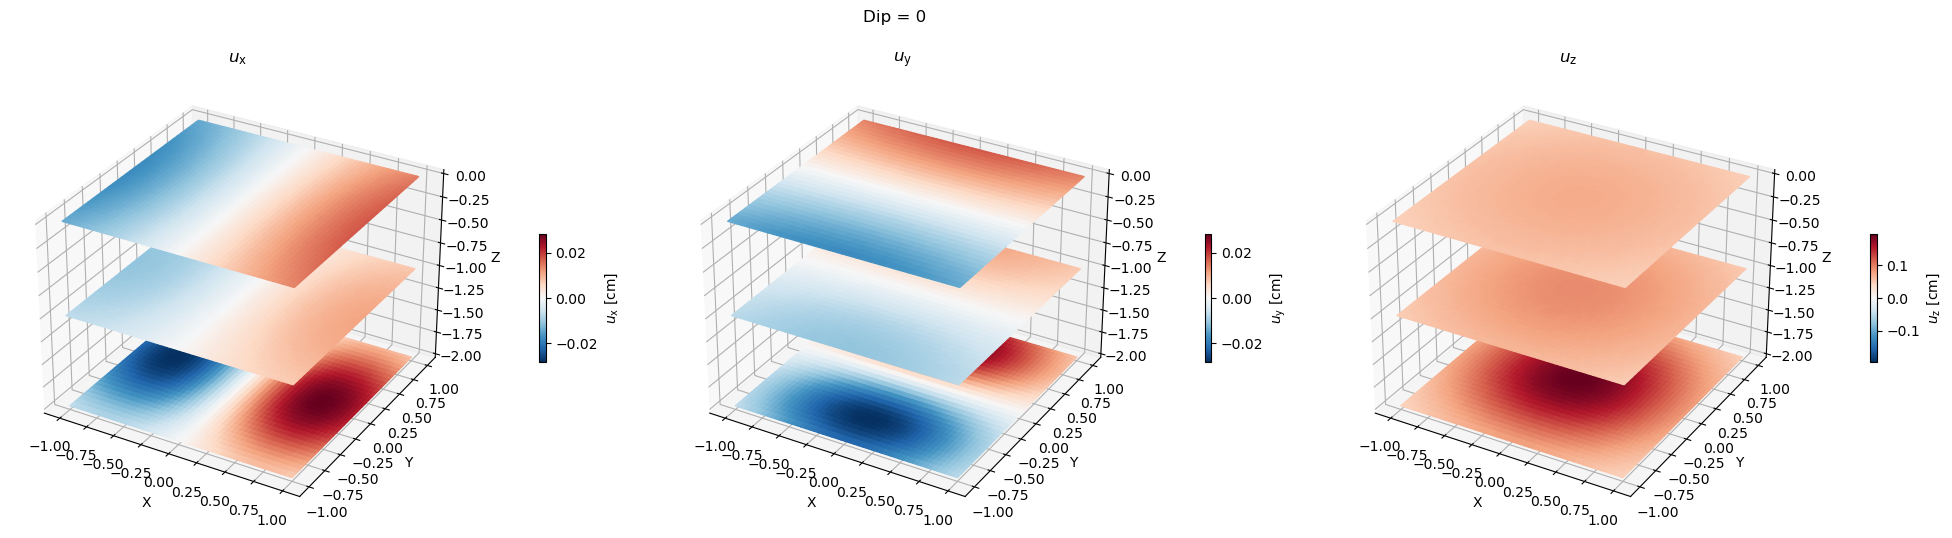

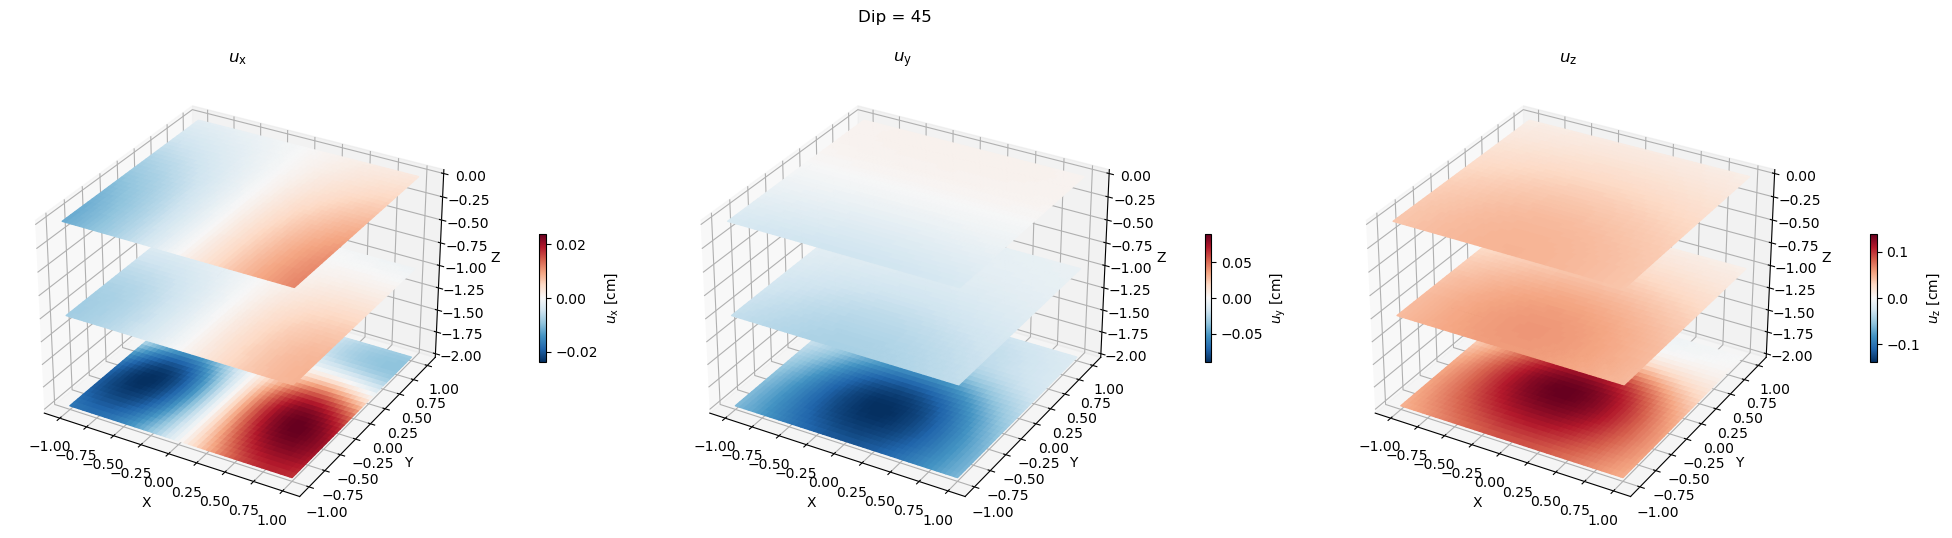

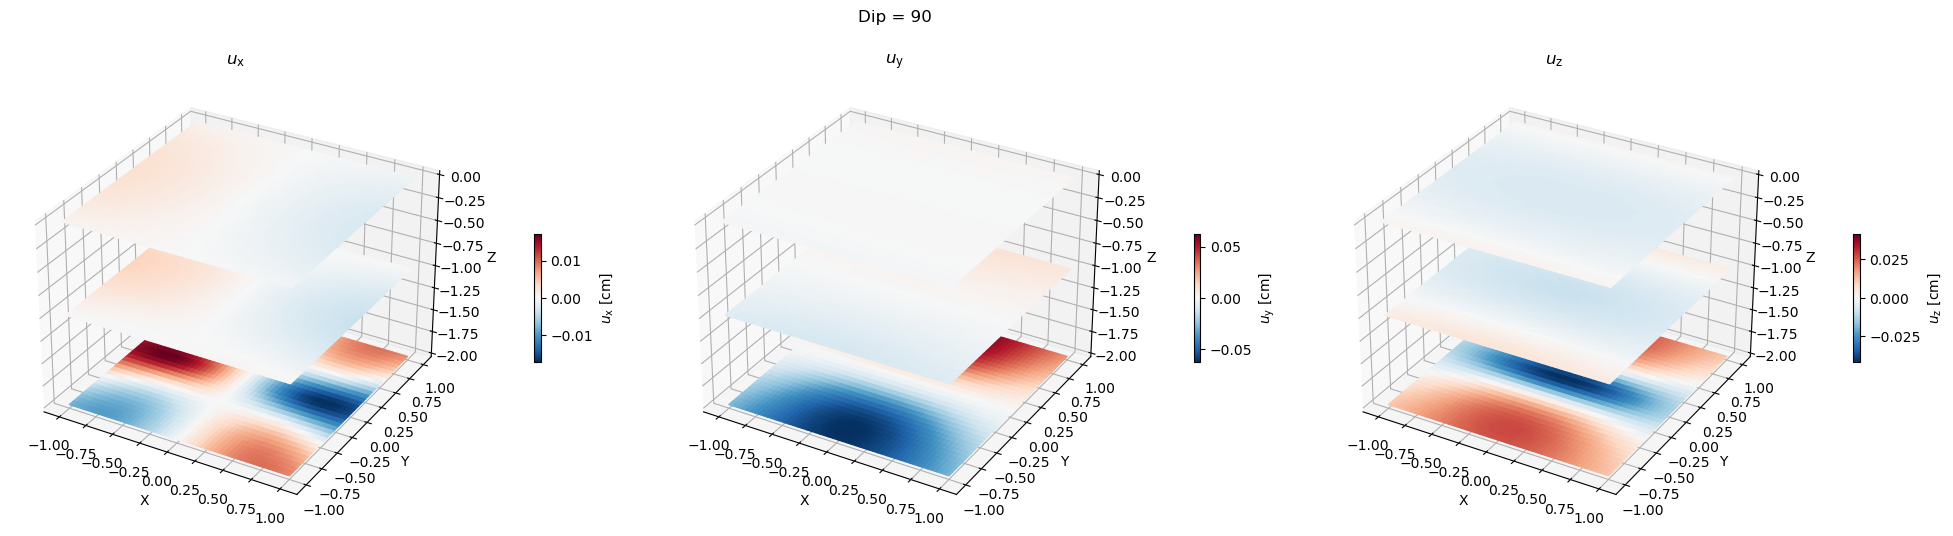

Elapsed time: 12.095866203308105 seconds


In [8]:
# run calculations for a tensile opening of 1 
disl1 = 0 # strike
disl2 = 0 # dip
disl3 = 1 # tensile
U_tensile = np.zeros(n)
start_time = time.time()
for i in range(n[2]):
    U = DC3D(alpha,X,Y,-Z,source_depth,dips[i],patch_dim[0],patch_dim[1],patch_dim[2],patch_dim[3],disl1,disl2,disl3)
    plot3D(X,Y,Z,U,dips[i])
    U_tensile[...,i,:] = np.transpose(U, (1, 0, 2, 3))
elapsed_time = time.time() - start_time 
print(f"Elapsed time: {elapsed_time} seconds")

# Validating results with Okada 85
In this section, I will load results from Stacy Larochelle's unit tests using a validated okada 85 script in matlab. I will plot the differences between my results and hers, along with calculating a maximum difference.

In [9]:
# Load unit tests done with Stacy Larochelle's Okada85 matlab scripts
def load_results_mat(filename):
    folder = 'Okada_unit_tests'
    file_path = os.path.join(folder, filename)
    mat_data = scipy.io.loadmat(file_path)
    ux = mat_data['u_x_arr']
    uy =  mat_data['u_y_arr']
    uz = mat_data['u_z_arr']
    return ux, uy, uz

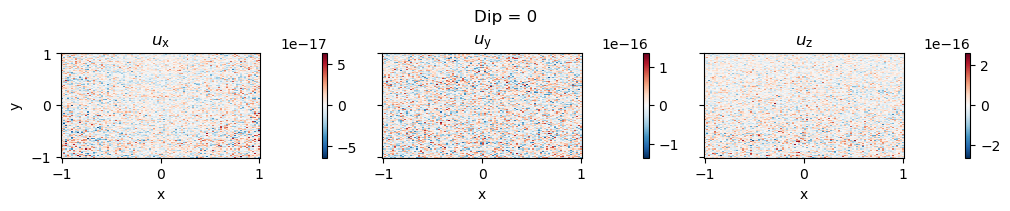

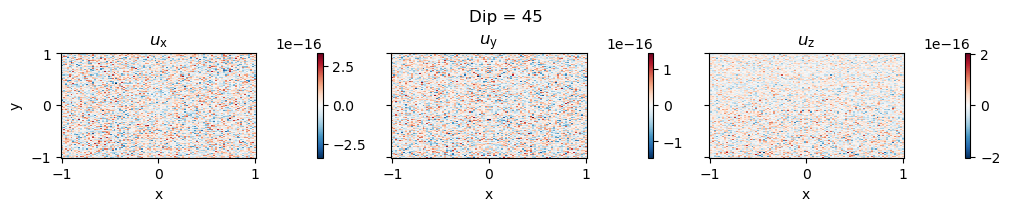

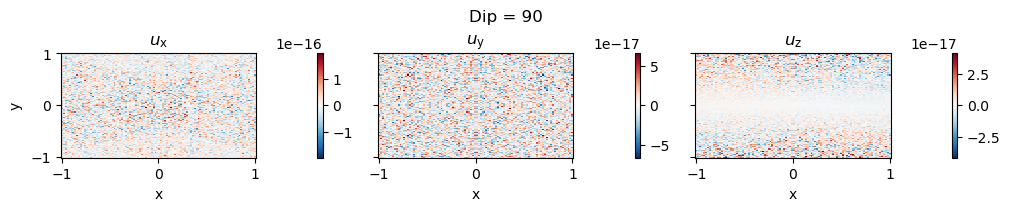

In [10]:
# Strike slip
ux, uy, uz = load_results_mat('strike_mat.mat')
diffx = np.transpose(U_strike[:,:,0,:,0], (1, 0, 2))-ux
diffy = np.transpose(U_strike[:,:,0,:,1], (1, 0, 2))-uy
diffz = np.transpose(U_strike[:,:,0,:,2], (1, 0, 2))-uz

#print(f'Max difference for strike slip is {np.max(diff)} cm')
for k in range(3):
    plot_displacements(diffx[:,:,k],diffy[:,:,k],diffz[:,:,k],dips[k])

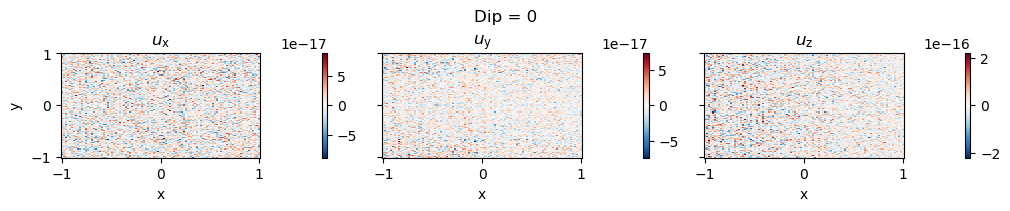

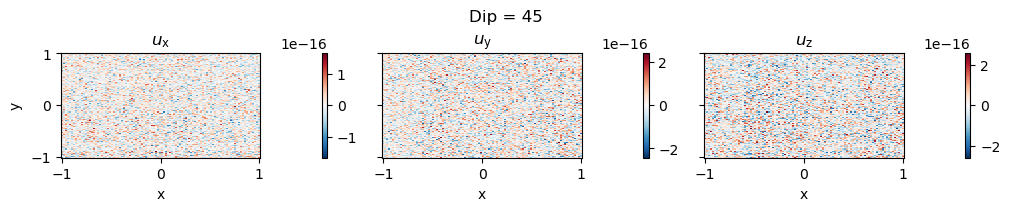

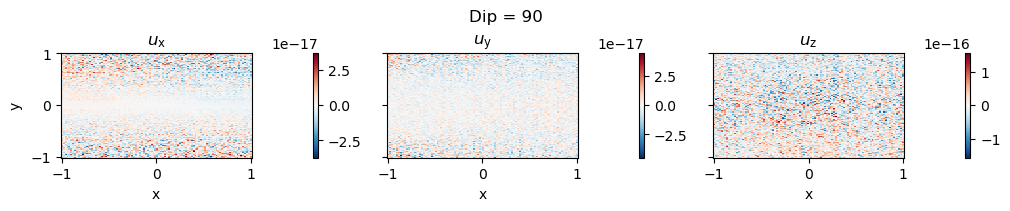

In [11]:
# Dip slip
ux, uy, uz = load_results_mat('dip_mat.mat')
diffx = np.transpose(U_dip[:,:,0,:,0], (1, 0, 2))-ux
diffy = np.transpose(U_dip[:,:,0,:,1], (1, 0, 2))-uy
diffz = np.transpose(U_dip[:,:,0,:,2], (1, 0, 2))-uz

#print(f'Max difference for dip slip is {np.max(diff)} cm')
for k in range(3):
    plot_displacements(diffx[:,:,k],diffy[:,:,k],diffz[:,:,k],dips[k])

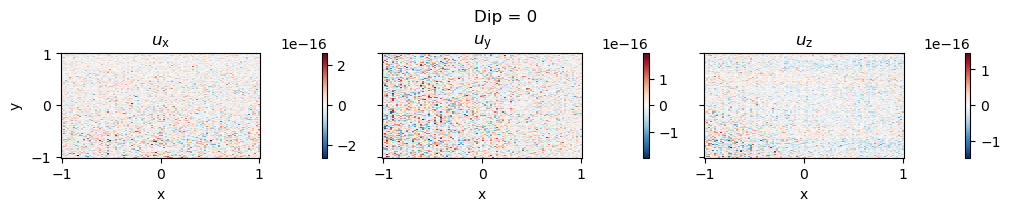

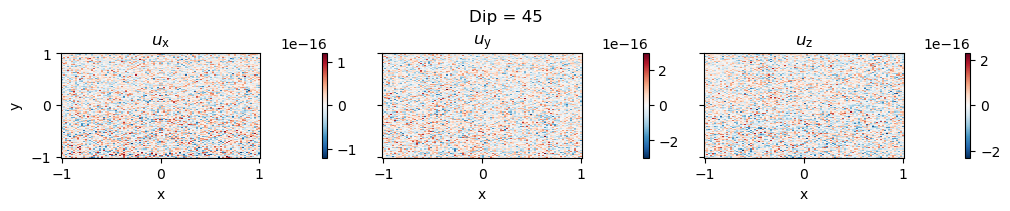

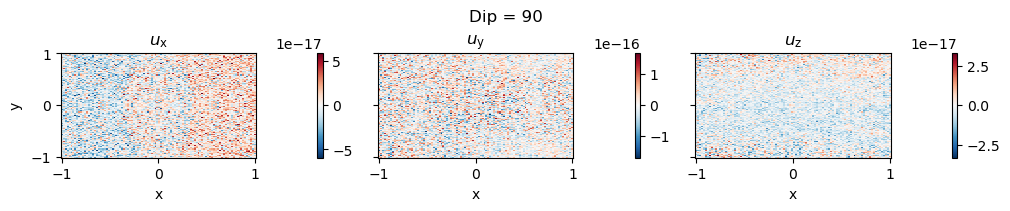

In [12]:
# Tensile
ux, uy, uz = load_results_mat('tensile_mat.mat')
diffx = np.transpose(U_tensile[:,:,0,:,0], (1, 0, 2))-ux
diffy = np.transpose(U_tensile[:,:,0,:,1], (1, 0, 2))-uy
diffz = np.transpose(U_tensile[:,:,0,:,2], (1, 0, 2))-uz

#print(f'Max difference for tensile opening is {np.max(diff)} cm')
for k in range(3):
    plot_displacements(diffx[:,:,k],diffy[:,:,k],diffz[:,:,k],dips[k])

In [13]:
print(np.finfo(float).eps)

2.220446049250313e-16
